In [2]:
import shared_functions
#下面用到什么定义就从shared_functions中载入
from shared_functions import read_from_files
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random
import torch
import sklearn
from sklearn import *
from shared_functions import performance_assessment
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

import graphviz
import xgboost
# For imbalanced learning
import imblearn
import warnings
warnings.filterwarnings('ignore')
from shared_functions import training_loop

In [3]:
DIR_INPUT='D:/Credit Card Fraud Detection/simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 469 ms
Wall time: 2.64 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [4]:
from shared_functions import get_train_test_set, scaleData
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
delta_valid = delta_test
start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)
# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

In [9]:
train_df['CUSTOMER_ID'].value_counts()  # To count occurrences of each customer ID
train_df['TX_FRAUD'].value_counts()  # To count occurrences of each fraud label (1 or 0)

TX_FRAUD
0    66295
1      633
Name: count, dtype: int64

In [10]:
valid_df['CUSTOMER_ID'].value_counts()  # To count occurrences of each customer ID
valid_df['TX_FRAUD'].value_counts()  # To count occurrences of each fraud label (1 or 0)

TX_FRAUD
0    58131
1      374
Name: count, dtype: int64

In [27]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

Selected device is cuda


In [28]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

In [29]:
print(len(x_train))
print(len(x_valid))

66928
58505


In [30]:
# new Dataset: FraudDatasetUnsupervised, which only receives the descriptive features of the transaction x
# and returns it as both input and output.去掉标签的数据
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [31]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

In [32]:
from shared_functions import prepare_generators

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

In [33]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [34]:
criterion = torch.nn.MSELoss().to(DEVICE)

In [35]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [36]:
seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = per_sample_mse(model, valid_generator)#每个样本的loss这样有助于发现异常值

In [37]:
print(losses[0:5])
print(np.mean(losses))

[0.6754841, 0.7914626, 1.1697073, 0.80701494, 1.258897]
0.9325166


In [38]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model,training_execution_time,train_losses,valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=100,
                                                                        apply_early_stopping=True,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572418479402026
valid loss: 0.11789108314475075
New best score: 0.11789108314475075

Epoch 1: train loss: 0.08445224534705936
valid loss: 0.0447379731822535
New best score: 0.0447379731822535

Epoch 2: train loss: 0.0381344485908647
valid loss: 0.028129147312761657
New best score: 0.028129147312761657

Epoch 3: train loss: 0.023945544768894093
valid loss: 0.016839703536831615
New best score: 0.016839703536831615

Epoch 4: train loss: 0.013857111910422177
valid loss: 0.009604522070842362
New best score: 0.009604522070842362

Epoch 5: train loss: 0.0076831335657726735
valid loss: 0.005340844840116677
New best score: 0.005340844840116677

Epoch 6: train loss: 0.005278851725178883
valid loss: 0.004115554313506178
New best score: 0.004115554313506178

Epoch 7: train loss: 0.0040532457875978225
valid loss: 0.003135783030890702
New best score: 0.003135783030890702

Epoch 8: train loss: 0.0030778856732326973
valid loss: 0.0025028832521432082
New best score: 0.00250288

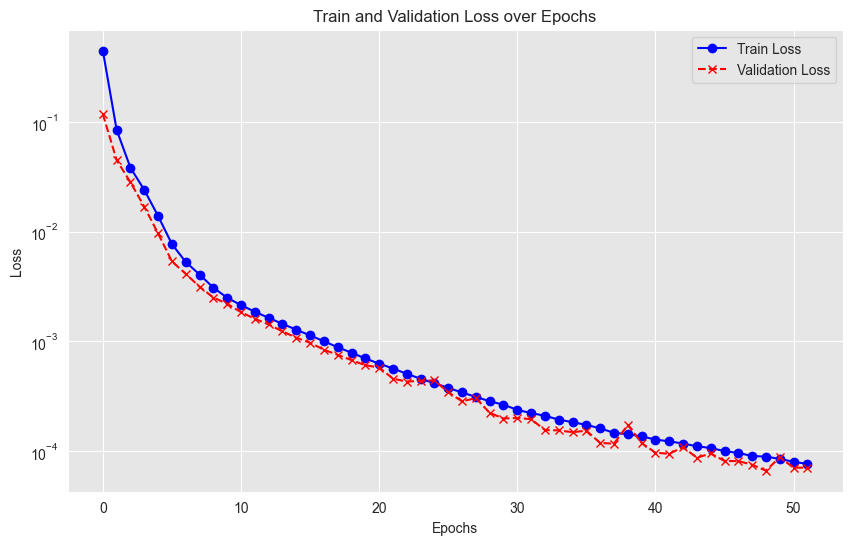

In [39]:
plt.figure(figsize=(10, 6))
plt.yscale('log')    
    # Plot training loss
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    
    # Plot validation loss
plt.plot(valid_losses, label='Validation Loss', color='red', linestyle='--', marker='x')
    
    # Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
    
    # Adding legend
plt.legend()
    
    # Displaying the plot
plt.grid(True)
plt.show()

In [40]:
losses = per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.268305e-05, 2.8324459e-05, 3.6242367e-05, 4.6025445e-05, 3.5767283e-05]
7.0288675e-05


In [41]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
tensor([-0.1358, -0.6267,  2.1802, -0.2965,  0.1197, -1.6986,  0.5020, -1.6774,
        -0.0492, -0.9771, -0.0745, -1.9801, -0.1176, -0.9701, -0.1372],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [42]:
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.0013673021
Average genuine reconstruction error: 6.194402e-05


In [43]:
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.84,0.163,0.199


In [44]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=SEED, n_estimators=10)
anomalyclassifier.fit(train_df[input_features])

IsolationForest(n_estimators=10, random_state=42)

In [30]:
predictions_df = valid_df
predictions_df['predictions'] = -anomalyclassifier.score_samples(valid_df[input_features])
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.808,0.164,0.19


Confusion Matrix:
[[52535  5596]
 [  119   255]]
True Positives: 255
False Positives: 5596
True Negatives: 52535
False Negatives: 119


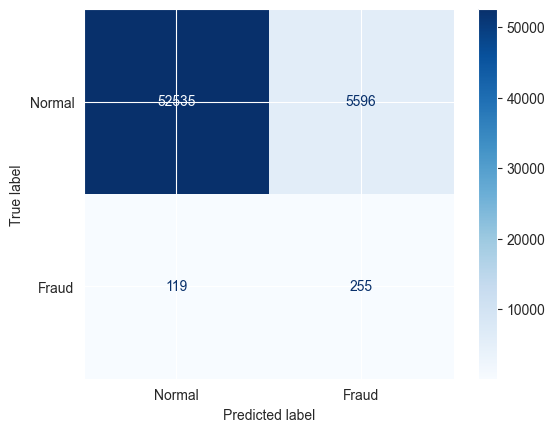

Average fraud reconstruction error: 0.0013673021
Average genuine reconstruction error: 6.194402e-05


In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Blues')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))



In [53]:
print(classification_report(y_valid, y_pred))
roc_auc = roc_auc_score(y_valid, y_pred)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     58131
         1.0       0.04      0.68      0.08       374

    accuracy                           0.90     58505
   macro avg       0.52      0.79      0.52     58505
weighted avg       0.99      0.90      0.94     58505

ROC AUC Score:  0.7927764250337404


In [22]:
#############
import math
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self, init_sigma=1.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [26]:
training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)


Epoch 0: train loss: 0.4801554326074871
valid loss: 0.15357966492247713

Epoch 1: train loss: 0.0921478882239665
valid loss: 0.04744079756687899

Epoch 2: train loss: 0.0330417514093092
valid loss: 0.020754964225238464

Epoch 3: train loss: 0.017649964555870052
valid loss: 0.013359206616166023

Epoch 4: train loss: 0.01189787863899756
valid loss: 0.008477815929189569

Epoch 5: train loss: 0.006354500696527813
valid loss: 0.004076999270667633

Epoch 6: train loss: 0.0043172284082178365
valid loss: 0.003281363929224918

Epoch 7: train loss: 0.0034640356044669638
valid loss: 0.002469158907359863

Epoch 8: train loss: 0.002496177430890579
valid loss: 0.0016904535621933925

Epoch 9: train loss: 0.001526000322144119
valid loss: 0.0010050065259454273

Epoch 10: train loss: 0.001057495153180758
valid loss: 0.0008060644015916649

Epoch 11: train loss: 0.0008567467341179484
valid loss: 0.0006993157954828029

Epoch 12: train loss: 0.0007324418242289337
valid loss: 0.0006292424551491203

Epoch 13

In [46]:
losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

NameError: name 'modelG' is not defined

In [31]:
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.842,0.241,0.229


Confusion Matrix:
[[52539  5592]
 [  115   259]]
True Positives: 259
False Positives: 5592
True Negatives: 52539
False Negatives: 115


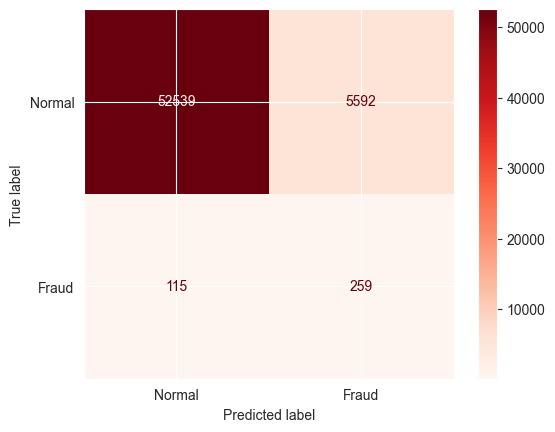

Average fraud reconstruction error: 0.0015619656
Average genuine reconstruction error: 9.333908e-05


In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [33]:
Accuracy (准确率) ≈ 0.904
Precision (精确率) ≈ 0.044
Recall (召回率) ≈ 0.692
F1-Score ≈ 0.083
Specificity (特异度) ≈ 0.903
False Positive Rate (假阳性率) ≈ 0.096
False Negative Rate (假阴性率) ≈ 0.307

SyntaxError: invalid character '≈' (U+2248) (2436469210.py, line 1)

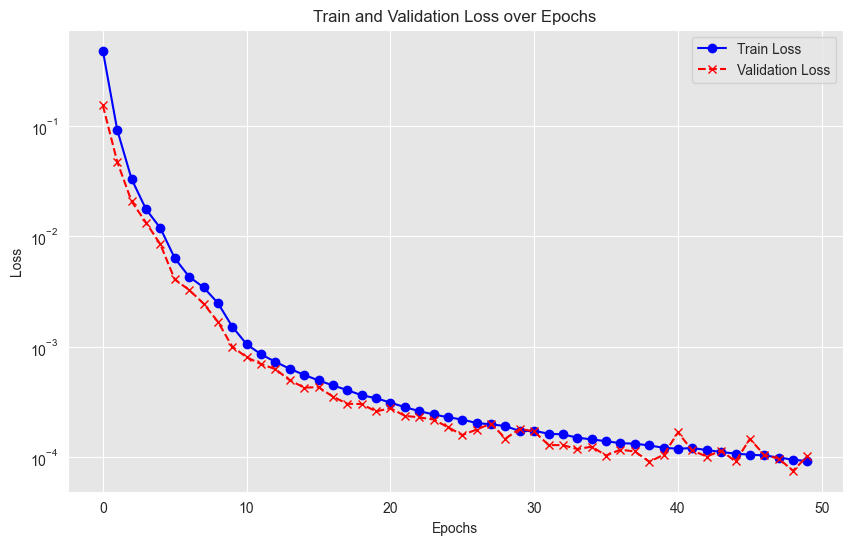

In [37]:
plt.figure(figsize=(10, 6))
plt.yscale('log')    
    # Plot training loss
plt.plot(train_lossesG, label='Train Loss', color='blue', linestyle='-', marker='o')
    
    # Plot validation loss
plt.plot(valid_lossesG, label='Validation Loss', color='red', linestyle='--', marker='x')
    
    # Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
    
    # Adding legend
plt.legend()
    
    # Displaying the plot
plt.grid(True)
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
print(classification_report(y_valid, y_pred))
roc_auc = roc_auc_score(y_valid, y_pred)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     58131
         1.0       0.04      0.69      0.08       374

    accuracy                           0.90     58505
   macro avg       0.52      0.80      0.52     58505
weighted avg       0.99      0.90      0.94     58505

ROC AUC Score:  0.7981584236672895


In [47]:
#########改初值
#############
import math
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self, init_sigma=0.5):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.5):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)


Epoch 0: train loss: 0.4420469033230901
valid loss: 0.11140690353073057

Epoch 1: train loss: 0.07517300159750545
valid loss: 0.03977502909148

Epoch 2: train loss: 0.029419197542432617
valid loss: 0.017647975290326474

Epoch 3: train loss: 0.014207540283845042
valid loss: 0.00916413855560816

Epoch 4: train loss: 0.007844534772047577
valid loss: 0.005495424914463866

Epoch 5: train loss: 0.005466894069009854
valid loss: 0.0040693391242975505

Epoch 6: train loss: 0.004088245959169842
valid loss: 0.0032305770239390717

Epoch 7: train loss: 0.0029112581367538547
valid loss: 0.0020700234737847756

Epoch 8: train loss: 0.001992721781361649
valid loss: 0.0015155066229667656

Epoch 9: train loss: 0.0014812255882120284
valid loss: 0.0011078341778169279

Epoch 10: train loss: 0.00120312226211686
valid loss: 0.0010520818785769365

Epoch 11: train loss: 0.001001496634795108
valid loss: 0.0007773612704143295

Epoch 12: train loss: 0.0008459385541440424
valid loss: 0.0007070219199252035

Epoch 1

In [48]:
losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

[3.047737e-05, 4.1591647e-05, 0.000113189475, 2.7189413e-05, 0.00012209086]
8.50918e-05
Average fraud reconstruction error: 0.0021115248
Average genuine reconstruction error: 7.2054245e-05


In [49]:
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.85,0.239,0.231


In [51]:
#########改初值
#############
import math
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self, init_sigma=0.7):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.7):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.4505864835805464
valid loss: 0.11137574654215021

Epoch 1: train loss: 0.0702737817241602
valid loss: 0.03306534517088223

Epoch 2: train loss: 0.027271422790808613
valid loss: 0.018015401621089607

Epoch 3: train loss: 0.01449576096634165
valid loss: 0.009366607020196855

Epoch 4: train loss: 0.007578503409263466
valid loss: 0.005171048709145579

Epoch 5: train loss: 0.005258664165589652
valid loss: 0.003914399425463517

Epoch 6: train loss: 0.004042514926512649
valid loss: 0.0029763917652432057

Epoch 7: train loss: 0.00290356499325915
valid loss: 0.002038221231145184

Epoch 8: train loss: 0.00193000383306487
valid loss: 0.0014549714885906525

Epoch 9: train loss: 0.0014046264635835263
valid loss: 0.0010920858373254783

Epoch 10: train loss: 0.0011447480724522145
valid loss: 0.0009940466289777472

Epoch 11: train loss: 0.0009547523186692566
valid loss: 0.0008654544356118765

Epoch 12: train loss: 0.0008106470711199375
valid loss: 0.0006661792580754613

Epoch 1

,AUC ROC,Average precision,Card Precision@100
0,0.835,0.254,0.233


Confusion Matrix:
[[52542  5589]
 [  112   262]]
True Positives: 262
False Positives: 5589
True Negatives: 52542
False Negatives: 112


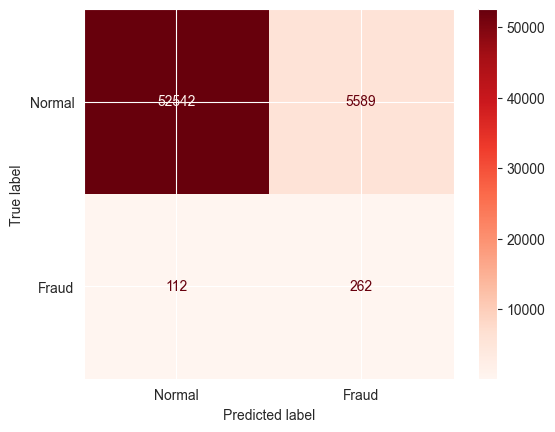

Average fraud reconstruction error: 0.0026244575
Average genuine reconstruction error: 0.00010067409


In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [53]:
print(modelG.gelu1.sigma)  # prints the sigma value of the first GELU
print(modelG.gelu2.sigma)  # prints the sigma value of the second GELU
print(modelG.gelu3.sigma)  # prints the sigma value of the third GELU

Parameter containing:
tensor(2.3072, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.0632, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.1169, device='cuda:0', requires_grad=True)


In [54]:
class GELU(nn.Module):
    def __init__(self, init_sigma=0.7):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(GELU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return output

class SimpleAutoencoderG(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.8):
            super(SimpleAutoencoderG, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.gelu1 = GELU(init_sigma=init_sigma)  
            self.gelu2 = GELU(init_sigma=init_sigma)
            self.gelu3 = GELU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.gelu1(hidden)
            
            code = self.fc2(hidden)
            code = self.gelu2(code)
 
            hidden = self.fc3(code)
            hidden = self.gelu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelG = SimpleAutoencoderG(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelG.parameters(), lr = 0.0001)
modelG,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelG,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelG, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.461449390181107
valid loss: 0.15222667120193523

Epoch 1: train loss: 0.08001966774107508
valid loss: 0.038222065627004934

Epoch 2: train loss: 0.03294765920134308
valid loss: 0.021645913298542055

Epoch 3: train loss: 0.016976416746268395
valid loss: 0.00944622580033264

Epoch 4: train loss: 0.007917335282532181
valid loss: 0.005375476131378546

Epoch 5: train loss: 0.0055957312909815015
valid loss: 0.0041531099507819275

Epoch 6: train loss: 0.004555722114934549
valid loss: 0.003445546520756853

Epoch 7: train loss: 0.003739255659876972
valid loss: 0.0027251403011595374

Epoch 8: train loss: 0.0028765398918172026
valid loss: 0.001989157086421476

Epoch 9: train loss: 0.001918293324803994
valid loss: 0.001286953099738664

Epoch 10: train loss: 0.0012503551006444907
valid loss: 0.0009051893366045252

Epoch 11: train loss: 0.0009664153083326405
valid loss: 0.0007487494541749439

Epoch 12: train loss: 0.0008115353711658597
valid loss: 0.0006313999518726653

Epoch

,AUC ROC,Average precision,Card Precision@100
0,0.842,0.234,0.236


Confusion Matrix:
[[52539  5592]
 [  115   259]]
True Positives: 259
False Positives: 5592
True Negatives: 52539
False Negatives: 115


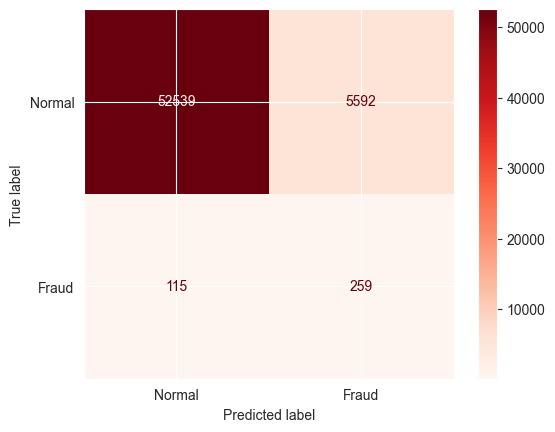

Average fraud reconstruction error: 0.0018327978
Average genuine reconstruction error: 0.00014125189


In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [56]:
print(modelG.gelu1.sigma)  # prints the sigma value of the first GELU
print(modelG.gelu2.sigma)  # prints the sigma value of the second GELU
print(modelG.gelu3.sigma)  # prints the sigma value of the third GELU

Parameter containing:
tensor(2.3696, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.0733, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.2155, device='cuda:0', requires_grad=True)


In [57]:
####################
###########SiLU
class SiLU(nn.Module):
    def __init__(self, init_sigma=1.0):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=1.0):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])


Epoch 0: train loss: 0.500212016129015
valid loss: 0.1814925249727046

Epoch 1: train loss: 0.12222507215651682
valid loss: 0.06434968374873119

Epoch 2: train loss: 0.04002108364357091
valid loss: 0.023043400237509788

Epoch 3: train loss: 0.019308568760182845
valid loss: 0.013238235264812988

Epoch 4: train loss: 0.011066224565818536
valid loss: 0.00667190967239643

Epoch 5: train loss: 0.005702006926423519
valid loss: 0.00395669007961399

Epoch 6: train loss: 0.004242292520199256
valid loss: 0.0032139300884007184

Epoch 7: train loss: 0.003497680617108172
valid loss: 0.0025762341807143447

Epoch 8: train loss: 0.0027609099966765917
valid loss: 0.0019325363601155863

Epoch 9: train loss: 0.0018223898249244705
valid loss: 0.0013742081308864627

Epoch 10: train loss: 0.0010651263983650437
valid loss: 0.0007475208918897364

Epoch 11: train loss: 0.0007883843931438041
valid loss: 0.0006094908731883961

Epoch 12: train loss: 0.0006565168105347624
valid loss: 0.0005121053439975955

Epoch 

,AUC ROC,Average precision,Card Precision@100
0,0.851,0.286,0.23


Confusion Matrix:
[[52546  5585]
 [  108   266]]
True Positives: 266
False Positives: 5585
True Negatives: 52546
False Negatives: 108


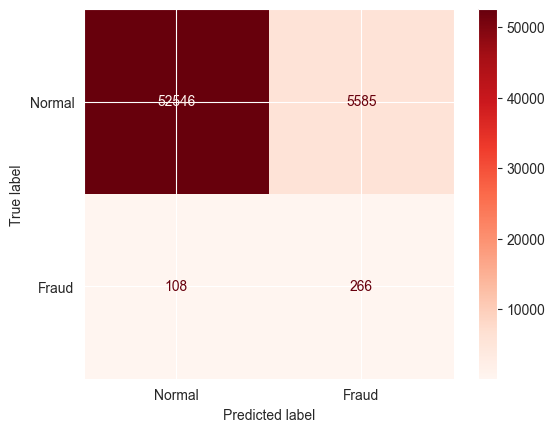

Average fraud reconstruction error: 0.001937864
Average genuine reconstruction error: 6.207694e-05


In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Assuming 'losses' are already computed for validation set (this could be MSE or other loss values)
# You should have a tensor or numpy array of losses for validation samples
# Here, losses = model reconstruction errors for each sample

# 1. Compute the threshold (you can choose the threshold based on the desired percentile or empirical testing)
threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [59]:
print(modelS.silu1.sigma)  # prints the sigma value of the first GELU
print(modelS.silu2.sigma)  # prints the sigma value of the second GELU
print(modelS.silu3.sigma)  # prints the sigma value of the third GELU

Parameter containing:
tensor(2.0159, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.4459, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.1237, device='cuda:0', requires_grad=True)



Epoch 0: train loss: 0.4711240579019769
valid loss: 0.1533132433484161

Epoch 1: train loss: 0.0972328306145496
valid loss: 0.048288314647036173

Epoch 2: train loss: 0.03522171347756402
valid loss: 0.022511267598942328

Epoch 3: train loss: 0.01949911179416323
valid loss: 0.014199476953738374

Epoch 4: train loss: 0.012305422115315956
valid loss: 0.008900410465672205

Epoch 5: train loss: 0.006954568444241914
valid loss: 0.004150783212198952

Epoch 6: train loss: 0.004407778563824648
valid loss: 0.003273908981844742

Epoch 7: train loss: 0.0036639481138288407
valid loss: 0.002755680827861601

Epoch 8: train loss: 0.003055548681686125
valid loss: 0.002205269787806631

Epoch 9: train loss: 0.0022571293622020267
valid loss: 0.0014408820248946873

Epoch 10: train loss: 0.0013352975175946588
valid loss: 0.0008450103239817901

Epoch 11: train loss: 0.0008517726404408979
valid loss: 0.0007423657565784788

Epoch 12: train loss: 0.0006805934508815924
valid loss: 0.0005236771506705204

Epoch 1

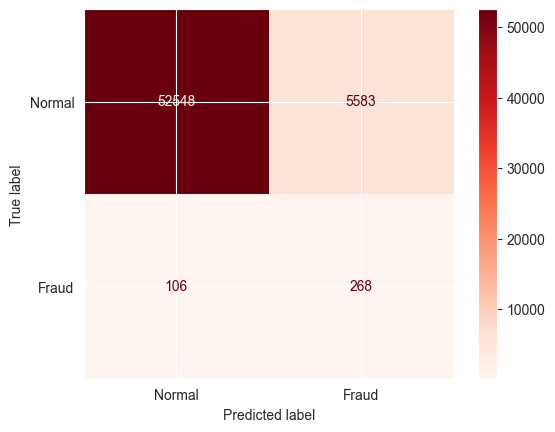

Average fraud reconstruction error: 0.0012728368
Average genuine reconstruction error: 8.1337996e-05


In [62]:
class SiLU(nn.Module):
    def __init__(self, init_sigma=0.8):# 将 sigma 定义为可学习参数给个初值3.0可以改，但是一定要写3.0，不能写3
        super(SiLU, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(init_sigma, dtype=torch.float32))
    
    def forward(self, input):
        output = input * torch.sigmoid(input / self.sigma)
        return output

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size, init_sigma=0.8):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.silu1 = SiLU(init_sigma=init_sigma)  
            self.silu2 = SiLU(init_sigma=init_sigma)
            self.silu3 = SiLU(init_sigma=init_sigma)
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.silu1(hidden)
            
            code = self.fc2(hidden)
            code = self.silu2(code)
 
            hidden = self.fc3(code)
            hidden = self.silu3(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
modelS = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)
optimizer = torch.optim.Adam(modelS.parameters(), lr = 0.0001)
modelS,training_execution_time,train_lossesG,valid_lossesG = training_loop(modelS,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=50,
                                                                        apply_early_stopping=False,
                                                                        verbose=True)
losses = per_sample_mse(modelS, valid_generator)
print(losses[0:5])
print(np.mean(losses))
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])

threshold = np.percentile(losses, 90)  # 90th percentile threshold for anomaly detection

# 2. Predict labels based on threshold (1: fraud, 0: normal)
y_pred = np.where(losses > threshold, 1, 0)

# 3. Convert y_valid to numpy array if it's a tensor (for confusion matrix compatibility)

# 4. Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# 5. Display confusion matrix using seaborn heatmap for better visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])
disp.plot(cmap='Reds')

# 6. Optionally, print the confusion matrix as well
print(f"Confusion Matrix:\n{cm}")
print(f"True Positives: {cm[1, 1]}")
print(f"False Positives: {cm[0, 1]}")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Negatives: {cm[1, 0]}")

# 7. Show the plot
plt.show()

# 8. Optionally, print the average reconstruction error for fraud and normal (genuine) samples
genuine_losses = np.array(losses)[y_valid == 0]
fraud_losses = np.array(losses)[y_valid == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

In [64]:
from shared_functions import performance_assessment
predictions_df=valid_df
predictions_df['predictions']=losses
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.846,0.206,0.221


In [65]:
print(modelS.silu1.sigma)  # prints the sigma value of the first GELU
print(modelS.silu2.sigma)  # prints the sigma value of the second GELU
print(modelS.silu3.sigma)  # prints the sigma value of the third GELU

Parameter containing:
tensor(2.0097, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(0.4589, device='cuda:0', requires_grad=True)
Parameter containing:
tensor(1.0257, device='cuda:0', requires_grad=True)
